In [1]:
using PyPlot
versioninfo()

Julia Version 0.6.2
Commit d386e40c17* (2017-12-13 18:08 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


# Overview

The aim of this notebook is to implement the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm for the famous [Ising model](https://en.wikipedia.org/wiki/Ising_model). Another goal is to explore Julia's versatility in creating efficient abstractions for generic N-dimensional grids using parametric types and functions.

# 1. N-dimensional von Neumann Neighborhood

In a classical Ising model, all spins interact only with their nearest neighbors. For a rectangular lattice, this corresponds to the [von Neumann Neighborhood](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood). 

The helper function `neighborhood(dim, ind)` computes such a neighborhood for the element with index `ind` in a `D`-dimensional lattice with dimension `dim`. As per the convention for Ising models, the lattice is assumed to be periodic, thus `neighborhood` will always return an array of `2*D` indices. The library functions `ind2sub` and `sub2ind` makes working with multi-dimensional indices very simple in Julia.

TODO:

* Implement Moore Neighborhood (should be easy using Cartesian indexing, see https://julialang.org/blog/2016/02/iteration).

* Implement von Neumann Neighborhood with range r.

* Implement Dirichlet boudary condition (i.e. out-of-bounds elements are removed).

In [2]:
"""
    neighborhood(dim, ind) -> neighbors

Returns the von Neumann neighborhood `neighbors` of the index `ind` in a lattice with dimension `dim`.

Both `ind` and `neighbors` use linearized indices (plain integers). Periodic boundary condition is assumed, 
 so `neighbors` always has length `2*D`.
"""
function neighborhood(dim::NTuple{D,Int}, ind::Int) where {D}
    @assert 1 <= ind <= prod(dim)
    sub = ind2sub(dim, ind) # convert to D-dimensional subscript
    neighbors = Vector{Int}(2*D)
    nsub = Vector{Int}(D) # sub2ind(dim, nsub...) is one of the neighbors
    # The code is structured so that nsub is reused as much as possible, so 
    #  we need to first initialize it to sub.
    for d = 1:D
        nsub[d] = sub[d]
    end
    
    # Iterate through each dimension
    for d = 1:D
        # Construct the index to the + direction at dimension `d`, 
        #  taking into account wrapping at the boundary.
        if sub[d] == dim[d]
            nsub[d] = 1
        else
            nsub[d] = sub[d] + 1
        end
        neighbors[2*d - 1] = sub2ind(dim, nsub...)
        # Same procedure but for the - direction
        if sub[d] == 1
            nsub[d] = dim[d]
        else
            nsub[d] = sub[d] - 1
        end
        neighbors[2*d] = sub2ind(dim, nsub...)
        # Revert nsub to its original state
        nsub[d] = sub[d]
    end
    return neighbors
end
;

Testing `neighborhood`:

In [3]:
dim = (10,20,30); sub = (10,15,1)
ind = sub2ind(dim, sub...)
neighbors = neighborhood(dim, ind)
@show neighbors
print("The neighbors of ", sub, " in a ", dim, " lattice are:\n")
for nind in neighbors
    println(ind2sub(dim, nind))
end

neighbors = [141, 149, 160, 140, 350, 5950]
The neighbors of (10, 15, 1) in a (10, 20, 30) lattice are:
(1, 15, 1)
(9, 15, 1)
(10, 16, 1)
(10, 14, 1)
(10, 15, 2)
(10, 15, 30)


# 2. N-dimensional Ising Lattice

We are now in a position to implement a `Lattice` type to represent a particular configuration of a generic N-dimensional Ising lattice.

`Lattice` is structured to implement the `AbstractArray` interface. This comes handy in that a lot of methods for regular arrays can be used out of the box, such as pretty printing and iteration. Also by implementing `Lattice` as a container type we can make it immutable while retaining the ability to mutate its contents (i.e. the configuration)

In [4]:
struct Lattice{D} <: AbstractArray{Int, D}
    J::Float64 # interaction strength
    spins::Array{Int,D} # the configuration
end

# Constructor for a random spin configuration
Lattice(J::Float64, dims::Int...) = Lattice(J, rand([1,-1], dims...))

# Implements the AbstractArray interface
Base.size(l::Lattice) = size(l.spins)
Base.IndexStyle(::Type{<:Lattice}) = IndexLinear() # Use linear (flat) index style
Base.getindex(l::Lattice, ind::Int) = l.spins[ind]
Base.setindex!(l::Lattice, s::Int, ind::Int) = (@assert s in (-1, 1); l.spins[ind] = s)

# Methods related to the Ising model/M-H algorithm
# Note that by using linear indexing, we can write generic methods without considering the dimensionality
flip!(l::Lattice, ind) = l.spins[ind] *= -1 # flip spin(s)
local_energy(l::Lattice, ind::Int) = -l.J * l[ind] * sum(l[neighborhood(size(l), ind)]) # local (mean field) energy
total_energy(l::Lattice) = 0.5 * sum(local_energy(l, i) for i in eachindex(l)) # total energy (Hamiltonian)
magnetization(l::Lattice) = sum(l[i] for i in eachindex(l)) / length(l) # mean magnetization (aka the order parameter)
;

Example using `Lattice`:

In [5]:
l = Lattice(1.0, 4, 5)

4×5 Lattice{2}:
 -1  -1  -1  -1  -1
  1   1   1  -1  -1
 -1  -1  -1  -1  -1
  1   1   1  -1   1

In [6]:
ind = sub2ind(size(l), 2,2) # index for the (2,2) element
flip!(l, ind); l

4×5 Lattice{2}:
 -1  -1  -1  -1  -1
  1  -1   1  -1  -1
 -1  -1  -1  -1  -1
  1   1   1  -1   1

In [7]:
@show local_energy(l, ind)
@show total_energy(l)
@show magnetization(l)
;

local_energy(l, ind) = 0.0
total_energy(l) = -4.0
magnetization(l) = -0.4


# 3. The Metropolis-Hastings Algorithm

The Markov chain walker for the M-H algorithm is encapsulated in the `Walker` type, which in turn is a subtype of `AbstractWalker`. Although in this notebook only one concrete subtype is defined for `AbstractWalker`, we can easily implement other versions of MCMC walkers (e.g. a walker that flips a whole cluster instead of an individual spin at a time) by subtyping `AbstractWalker` and implement the `step!` and `getstate` methods. Since the sampling function `sample!` works for any `AbstractWalker`, it should work for the new algorithm as well.

In a typical MCMC simulation the configuration space is relatively large, and it can be quite expensive to store every snapshot during the simulation. The `step!` method is implemented so that only one `Lattice` is needed, and the evolution of energy/magnetization can be computed using the returned delta energy/magnetization.

In [8]:
abstract type AbstractWalker{D} end

struct Walker{D} <: AbstractWalker{D}
    temp::Float64 # temperature
    state::Lattice{D}
end

# Constructor for random state initialization
Walker(temp::Float64, J::Float64, dims::Int...) = Walker(temp, Lattice(J, dims...))
getstate(w::Walker) = w.state # accessor method for the configuration

"""
    step!(w) -> delta_h, delta_m

Simultates one step of the M-H walker. Returns the change in energy and magnetization.
"""
function step!(w::Walker)
    ind = rand(1:length(w.state)) # Propose to flip a random spin
    delta_h = -2 * local_energy(w.state, ind) # Energy difference for flipping the spin
    if delta_h < 0 || rand() < exp(-delta_h / w.temp) # accept proposal
        delta_m = -2 * w.state[ind] / length(w.state)
        flip!(w.state, ind)
    else # reject proposal 
        delta_h = 0.0
        delta_m = 0.0
    end
    return delta_h, delta_m
end

"""
    sample!(w, Nsamples) -> energy, mag

Obtain `Nsamples` samples of energy and magnetization by stepping the walker `w`.
"""
function sample!(w::AbstractWalker, Nsamples::Int)
    energy = Vector{Float64}(Nsamples)
    mag = Vector{Float64}(Nsamples)
    
    # First sample is from the initial state of w
    init_state = getstate(w)
    energy[1] = total_energy(init_state)
    mag[1] = magnetization(init_state)
    
    # Subsequent samples are obtained by stepping the walker
    for k = 2:Nsamples
        delta_h, delta_m = step!(w)
        energy[k] = energy[k-1] + delta_h
        mag[k] = mag[k-1] + delta_m
    end
    return energy, mag
end
;

Try out Metropolis-Hastings on a small 2D problem. This also gives us a rough idea of how many samples and burns to use.

In [9]:
dim = (20,20)
J = 1.0; temp = 2.0 # slightly below critical temperature
Nsamples = 500_000
walker = Walker(temp, J, dim...)
energy, mag = sample!(walker, Nsamples)
;

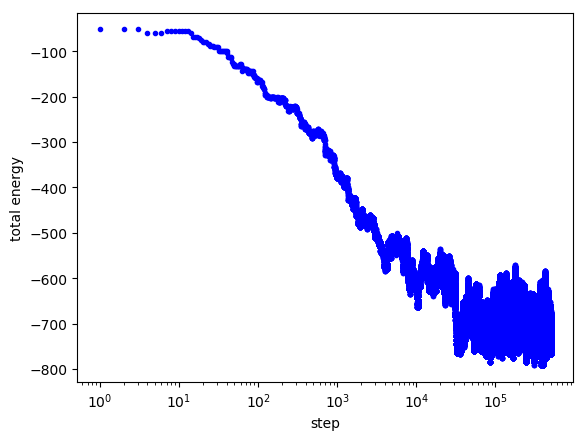

In [10]:
plot(1:Nsamples, energy, ".b")
semilogx()
xlabel("step")
ylabel("total energy")
;

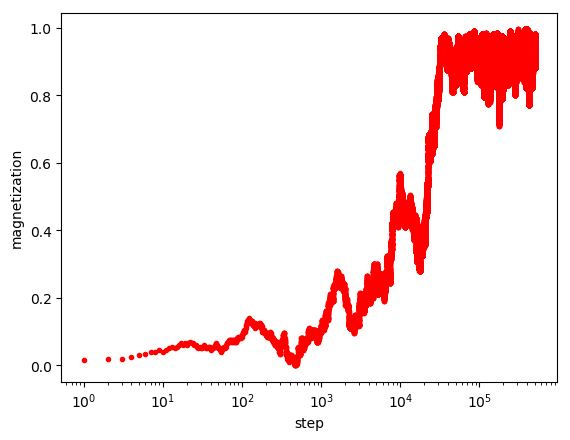

In [11]:
plot(1:Nsamples, mag, ".r")
semilogx()
xlabel("step")
ylabel("magnetization")
;

# 4. Observing the phase transition of a 2D Ising lattice

Feel free to change the parameters to test different scenarios! Switching from the 2D lattice to an N-dimensional one is as simple as changing `dim`.

TODO: parallelize the MCMC simulation

In [12]:
# Parameters
dim = (20,20) # dimension of the lattice
J = 1.0 # interaction strength
Tpts = 100 # number of temperature points to draw
Navg = 3 # how many trials to average for each temperature point
Nsamples = 500_000 # how many samples to generate for each trial
burn = 20_000 # how many initial samples to throw away

# We want more temperature points near the critical temperature, so we
#  draw the points from a normal distribution around Tc.
Tc = 2 * J / log(1 + sqrt(2)) # Onsager's critical temperature
Ts = Tc + randn(Tpts) * (Tc/5)
Ts = Ts[Ts .> 0]; Tpts = length(Ts) # strip negative temperatures

energy = zeros(Navg, Tpts)
absmag = zeros(Navg, Tpts)
println("Ising lattice with dimension ", dim, " and interaction strength ", J)
println("Beginning MCMC simulation...")
for j = 1:Tpts
    for i = 1:Navg
        # Sample a MCMC walker
        walker = Walker(Ts[j], J, dim...)
        Es, Ms = sample!(walker, Nsamples)
        # Compute time average
        energy[i,j] = sum(Es[burn+1:end]) / (Nsamples - burn)
        absmag[i,j] = abs(sum(Ms[burn+1:end])) / (Nsamples - burn)
    end
    
    # Print a progress bar
    progress = div(j * 20, Tpts) # progress on a scale of 1 to 20
    @printf("\r[%-20s] %d%%", repeat("=", progress), 5*progress)
end

energy = sum(energy, 1) / Navg
absmag = sum(absmag, 1) / Navg
;

Ising lattice with dimension (20, 20) and interaction strength 1.0
Beginning MCMC simulation...
[====================] 100%

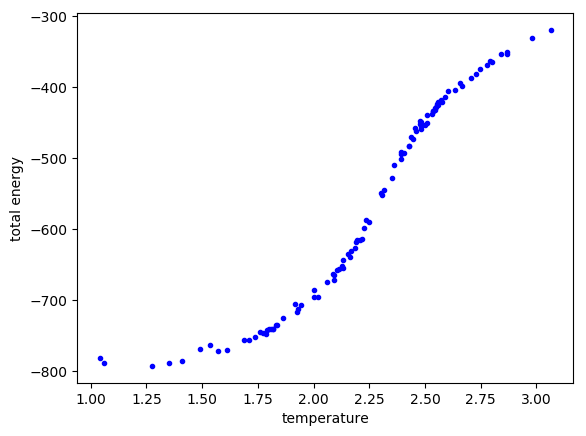

In [13]:
plot(Ts, energy', ".b")
xlabel("temperature")
ylabel("total energy")
;

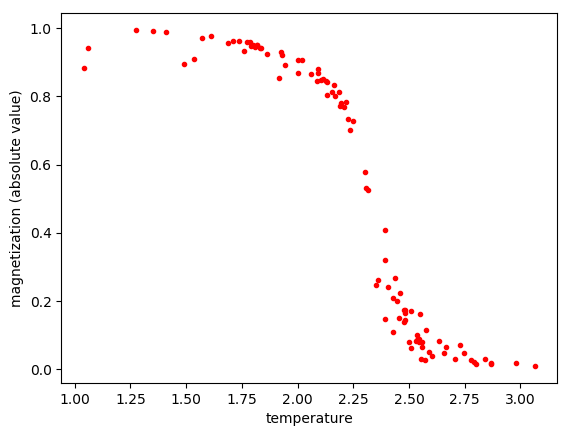

In [14]:
plot(Ts, absmag', ".r")
xlabel("temperature")
ylabel("magnetization (absolute value)")
;